## 0. Setup

In [ ]:

import os, math, time, pathlib
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import tensorflow as tf
from tensorflow.keras import layers

# Reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print(tf.__version__)


2.19.0



## 1. Data: MNIST
We will use MNIST and normalize images to `[-1, 1]` (so that the generator can use `tanh` in the last layer).


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


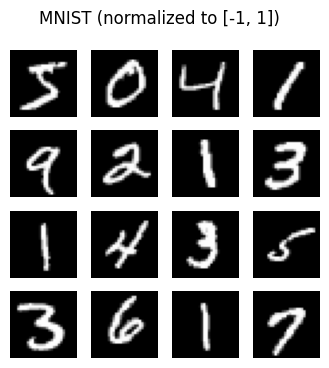

In [ ]:
BATCH_SIZE = 256
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
x_train = (x_train.astype("float32") - 127.5) / 127.5  # [-1, 1]
x_train = np.expand_dims(x_train, -1)                  # (N, 28, 28, 1)
train_ds = (tf.data.Dataset.from_tensor_slices((x_train, y_train))
            .shuffle(60000).batch(BATCH_SIZE, drop_remainder=True))

def show_grid(images, n=16, title=None, cmap="gray"):
    images = images[:n]
    side = int(math.sqrt(n))
    plt.figure(figsize=(4,4))
    for i in range(n):
        plt.subplot(side, side, i+1)
        # Check if the input is a TensorFlow tensor before calling .numpy()
        if isinstance(images, tf.Tensor):
            img = images[i, :, :, 0].numpy()
        else:
            img = images[i, :, :, 0]
        plt.imshow((img*127.5+127.5).astype(np.uint8), cmap=cmap, vmin=0, vmax=255)
        plt.axis("off")
    if title: plt.suptitle(title)
    plt.show()

show_grid(x_train, n=16, title="MNIST (normalized to [-1, 1])")


## 2. DCGAN Architecture

Implement a **Generator** (maps noise `z ~ N(0, I)` to images) and a **Discriminator** (binary real/fake classifier).

**Design choices:**
- Generator uses `Dense → Reshape → Conv2DTranspose` stack, with `BatchNorm` + `LeakyReLU`, final `tanh`.
- Discriminator uses `Conv2D` with stride 2, `LeakyReLU`, `Dropout`, final linear logit.


In [ ]:
NOISE_DIM = 100

def build_generator(noise_dim=NOISE_DIM):
    model = tf.keras.Sequential([
        layers.Input(shape=(noise_dim,)),
        layers.Dense(7*7*256, use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Reshape((7, 7, 256)),

        # Implement convolutional block #1
        layers.Conv2DTranspose(128, 5, strides=1, padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),

        # Implement convolutional block #2
        layers.Conv2DTranspose(64, 5, strides=2, padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),

        layers.Conv2DTranspose(1, 5, strides=2, padding="same", use_bias=False, activation="tanh"),
    ], name="generator")
    return model

In [ ]:
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Input(shape=(28, 28, 1)),

        # Implement discriminator convolutional block #1
        layers.Conv2D(64, 5, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),

        # Implement discriminator convolutional block #2
        layers.Conv2D(128, 5, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1)  # logits
    ], name="discriminator")
    return model

In [ ]:
G = build_generator()
D = build_discriminator()
G.summary(); D.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 128)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │         1,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)


## 3. Losses and Optimizers
Use the original GAN objective with **Binary Cross-Entropy** (logits) and Adam optimizers.


In [ ]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def d_loss(real_logits, fake_logits):
    real_loss = bce(tf.ones_like(real_logits), real_logits)
    fake_loss = bce(tf.zeros_like(fake_logits), fake_logits)
    return real_loss + fake_loss

def g_loss(fake_logits):
    return bce(tf.ones_like(fake_logits), fake_logits)

g_opt = tf.keras.optimizers.Adam(1e-4)
d_opt = tf.keras.optimizers.Adam(1e-4)

fixed_noise = tf.random.normal([16, NOISE_DIM])  # for consistent snapshots


## 4. Train DCGAN
Alternate updates: one step for D, one for G. We log losses and show sample grids periodically.


Epoch 30/30, G Loss: 1.0527, D Loss: 1.1466, Time: 13.47s


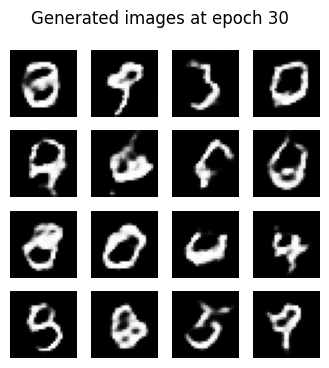

In [ ]:
@tf.function
def train_step_dcgan(x_real):
    noise = tf.random.normal([tf.shape(x_real)[0], NOISE_DIM])

    with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
        x_fake = G(noise, training=True)
        real_logits = D(x_real, training=True)
        fake_logits = D(x_fake, training=True)

        loss_d = d_loss(real_logits, fake_logits)
        loss_g = g_loss(fake_logits)

    d_grads = d_tape.gradient(loss_d, D.trainable_variables)
    g_grads = g_tape.gradient(loss_g, G.trainable_variables)
    d_opt.apply_gradients(zip(d_grads, D.trainable_variables))
    g_opt.apply_gradients(zip(g_grads, G.trainable_variables))
    return loss_g, loss_d

def train_dcgan(dataset, epochs=30, log_every=5):
    hist = {"g": [], "d": []}
    for epoch in range(1, epochs+1):
        start = time.time()
        g_loss_total, d_loss_total = 0, 0
        num_batches = 0
        for x_real, _ in dataset:
            loss_g, loss_d = train_step_dcgan(x_real)
            g_loss_total += loss_g
            d_loss_total += loss_d
            num_batches += 1

        avg_g_loss = g_loss_total / num_batches
        avg_d_loss = d_loss_total / num_batches
        hist["g"].append(avg_g_loss.numpy())
        hist["d"].append(avg_d_loss.numpy())


        if epoch % log_every == 0 or epoch == 1:
            clear_output(wait=True)
            print(f"Epoch {epoch}/{epochs}, G Loss: {avg_g_loss:.4f}, D Loss: {avg_d_loss:.4f}, Time: {time.time()-start:.2f}s")
            generated_images = G(fixed_noise, training=False)
            show_grid(generated_images, title=f"Generated images at epoch {epoch}")
    return hist

history = train_dcgan(train_ds, epochs=30, log_every=5)

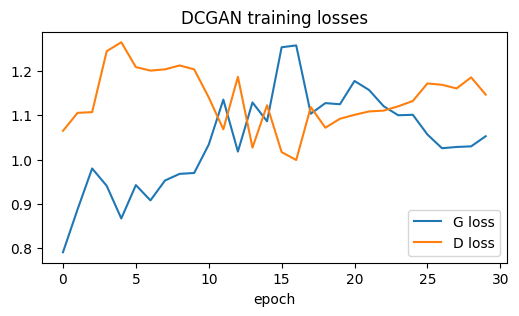

In [ ]:

plt.figure(figsize=(6,3))
plt.plot(history["g"], label="G loss")
plt.plot(history["d"], label="D loss")
plt.legend(); plt.title("DCGAN training losses"); plt.xlabel("epoch"); plt.show()



---
## 5. Conditional GAN (cGAN) on MNIST Labels

We condition **both** G and D on the digit label `y ∈ {0..9}`.
- Embed label, concatenate with noise for G.
- For D, concatenate a label map (1×28×28) with the image, or inject via projection (simpler here: concat).



In [ ]:
NUM_CLASSES = 10
EMBED_DIM = 16

class CondGenerator(tf.keras.Model):
    def __init__(self, noise_dim=NOISE_DIM, num_classes=NUM_CLASSES, embed_dim=EMBED_DIM):
        super().__init__()
        self.embed = layers.Embedding(num_classes, embed_dim)
        self.proj = layers.Dense(noise_dim, use_bias=False)
        self.core = build_generator(noise_dim=noise_dim)

    def call(self, z, y, training=False):
        e = self.embed(y)                     # (B, embed_dim)
        zc = z + self.proj(e)                 # simple additive conditioning
        return self.core(zc, training=training)

class CondDiscriminator(tf.keras.Model):
    def __init__(self, num_classes=NUM_CLASSES):
        super().__init__()
        self.embed = layers.Embedding(num_classes, 28*28)
        # Discriminator that takes 2-channel input: image + label map
        self.disc = tf.keras.Sequential([
            layers.Input(shape=(28,28,2)),
            layers.Conv2D(64, 5, strides=2, padding="same"),
            layers.LeakyReLU(0.2),
            layers.Dropout(0.3),
            layers.Conv2D(128, 5, strides=2, padding="same"),
            layers.LeakyReLU(0.2),
            layers.Dropout(0.3),
            layers.Flatten(), layers.Dense(1)
        ])

    def call(self, x, y, training=False):
        lab_map = tf.reshape(self.embed(y), (-1, 28, 28, 1))
        x_in = tf.concat([x, lab_map], axis=-1)
        return self.disc(x_in, training=training)

Gc = CondGenerator()
Dc = CondDiscriminator()

Epoch 15/15, G Loss: 1.0644, D Loss: 1.0929, Time: 13.92s


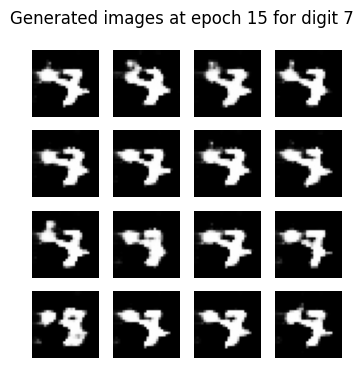

In [ ]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
g_opt_c = tf.keras.optimizers.Adam(1e-4)
d_opt_c = tf.keras.optimizers.Adam(1e-4)


@tf.function
def train_step_cgan(x_real, y_real):
    bs = tf.shape(x_real)[0]
    z = tf.random.normal([bs, NOISE_DIM])
    y_fake = tf.random.uniform([bs], minval=0, maxval=NUM_CLASSES, dtype=tf.int32)

    with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
        x_fake = Gc(z, y_fake, training=True)
        real_logits = Dc(x_real, y_real, training=True)
        fake_logits = Dc(x_fake, y_fake, training=True)

        loss_d = d_loss(real_logits, fake_logits)
        loss_g = g_loss(fake_logits)

    d_grads = d_tape.gradient(loss_d, Dc.trainable_variables)
    g_grads = g_tape.gradient(loss_g, Gc.trainable_variables)
    d_opt_c.apply_gradients(zip(d_grads, Dc.trainable_variables))
    g_opt_c.apply_gradients(zip(g_grads, Gc.trainable_variables))
    return loss_g, loss_d

def train_cgan(dataset, epochs=15, log_every=5, digit=7):
    # fixed label for visualization
    fixed_z = tf.random.normal([16, NOISE_DIM])
    fixed_y = tf.fill([16], digit)
    hist = {"g": [], "d": []}
    for epoch in range(1, epochs+1):
        start = time.time()
        g_loss_total, d_loss_total = 0, 0
        num_batches = 0
        for x_real, y_real in dataset:
            loss_g, loss_d = train_step_cgan(x_real, y_real)
            g_loss_total += loss_g
            d_loss_total += loss_d
            num_batches += 1

        avg_g_loss = g_loss_total / num_batches
        avg_d_loss = d_loss_total / num_batches
        hist["g"].append(avg_g_loss.numpy())
        hist["d"].append(avg_d_loss.numpy())

        if epoch % log_every == 0 or epoch == 1:
            clear_output(wait=True)
            print(f"Epoch {epoch}/{epochs}, G Loss: {avg_g_loss:.4f}, D Loss: {avg_d_loss:.4f}, Time: {time.time()-start:.2f}s")
            generated_images = Gc(fixed_z, fixed_y, training=False)
            show_grid(generated_images, title=f"Generated images at epoch {epoch} for digit {digit}")
    return hist

history_c = train_cgan(train_ds, epochs=15, log_every=5, digit=7)


---
## 6. WGAN-GP: Wasserstein GAN with Gradient Penalty

 Improve training stability and gradients by optimizing the **Earth Mover (Wasserstein) distance**.
- Critic (not discriminator) outputs a **real-valued score** (no sigmoid/BCE).
- Loss: maximize difference between real and fake scores (implemented as minimizing negative difference for G).
- Enforce **1-Lipschitz** constraint using **Gradient Penalty**.



Epoch 10/10, G Loss: 1.1937, C Loss: -1.8246, Time: 65.63s


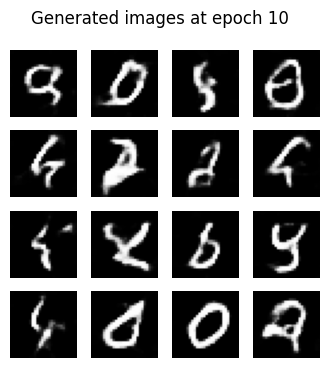

In [ ]:
LAMBDA_GP = 10.0

def build_critic():
    model = tf.keras.Sequential([
        layers.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, 5, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Conv2D(128, 5, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Flatten(),
        layers.Dense(1)  # score (no activation)
    ], name="critic")
    return model

Critic = build_critic()
G_w = build_generator()

g_opt_w = tf.keras.optimizers.Adam(1e-4) # adam optimizer
c_opt_w = tf.keras.optimizers.Adam(1e-4) # adam optimizer

def gradient_penalty(critic, real, fake):
    bs = tf.shape(real)[0]
    eps = tf.random.uniform([bs, 1, 1, 1], 0.0, 1.0)
    inter = eps * real + (1.0 - eps) * fake
    with tf.GradientTape() as gp_tape:
        gp_tape.watch(inter)
        pred = critic(inter, training=True)
    grads = gp_tape.gradient(pred, inter)
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1,2,3]) + 1e-8)
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp

@tf.function
def train_step_wgan_gp(x_real, n_critic=5):
    bs = tf.shape(x_real)[0]

    # update critic multiple times
    c_loss_total = 0.0
    for _ in range(n_critic):
        z = tf.random.normal([bs, NOISE_DIM])
        with tf.GradientTape() as c_tape:
            x_fake = G_w(z, training=True)
            score_real = Critic(x_real, training=True)
            score_fake = Critic(x_fake, training=True)
            gp = gradient_penalty(Critic, x_real, x_fake)
            c_loss = tf.reduce_mean(score_fake) - tf.reduce_mean(score_real) + LAMBDA_GP * gp
        c_grads = c_tape.gradient(c_loss, Critic.trainable_variables)
        c_opt_w.apply_gradients(zip(c_grads, Critic.trainable_variables))
        c_loss_total += c_loss

    # generator step
    z = tf.random.normal([bs, NOISE_DIM])
    with tf.GradientTape() as g_tape:
        x_fake = G_w(z, training=True)
        score_fake = Critic(x_fake, training=True)
        g_loss = -tf.reduce_mean(score_fake)
    g_grads = g_tape.gradient(g_loss, G_w.trainable_variables)
    g_opt_w.apply_gradients(zip(g_grads, G_w.trainable_variables))

    return g_loss, c_loss_total / n_critic

def train_wgan_gp(dataset, epochs=10, log_every=2):
    fixed_z = tf.random.normal([16, NOISE_DIM])
    hist = {"g": [], "c": []}
    for epoch in range(1, epochs+1):
        start = time.time()
        g_loss_total, c_loss_total = 0, 0
        num_batches = 0
        for x_real, _ in dataset:
            loss_g, loss_c = train_step_wgan_gp(x_real)
            g_loss_total += loss_g
            c_loss_total += loss_c
            num_batches += 1

        avg_g_loss = g_loss_total / num_batches
        avg_c_loss = c_loss_total / num_batches
        hist["g"].append(avg_g_loss.numpy())
        hist["c"].append(avg_c_loss.numpy())

        if epoch % log_every == 0 or epoch == 1:
            clear_output(wait=True)
            print(f"Epoch {epoch}/{epochs}, G Loss: {avg_g_loss:.4f}, C Loss: {avg_c_loss:.4f}, Time: {time.time()-start:.2f}s")
            generated_images = G_w(fixed_z, training=False)
            show_grid(generated_images, title=f"Generated images at epoch {epoch}")
    return hist

hist_w = train_wgan_gp(train_ds, epochs=10, log_every=2)